In [ ]:
'''
Author: Naixin && naixinguo2-c@my.cityu.edu.hk
Date: 2022-11-01 14:50:18
LastEditors: Naixin && naixinguo2-c@my.cityu.edu.hk
LastEditTime: 2022-11-01 14:52:17
FilePath: /Gtext/xiu/fixword_ex.ipynb
Description: 

'''

from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
import pandas as pd
import os
from tqdm import tqdm
import numpy as np
from sklearn.decomposition import TruncatedSVD
from scipy import sparse

##################### Could be changed part ##########################
sparse_folder = 'results_primary_news_sparse_multiyears/'
index_folder = 'results_primary_news_index_multiyears/'

sparse_file = '2005_2020_sparse/2005_2014_sparse_threecol.csv'
index_file = '2005_2020_index_news/2005_2014_index_news.csv'
word_file = '2005_2014_stemmed_word_count.csv'

sparse_file0 = '2005_2020_sparse/2015_2019_sparse_threecol.csv'
index_file0 = '2005_2020_index_news/2015_2019_index_news.csv'


sparse_file1 = '2005_2020_sparse/2020_2020_sparse_threecol.csv'
index_file1 = '2005_2020_index_news/2020_2020_index_news.csv'

######################################################################

######################## Could be put in the function module py file ########################
# Define a function to transform data from three columns to sparse matrix
def trans_data(sparse_data, news_data, word_data):
    '''
    :param sparse_data: the three column saved words DataFrame includes 'Row', 'Column', 'Value'
    :param news_data: news DataFrame includes 'Row_ID', 'permno', 'returnday_1', 'threedayreturn', 'title'
    :param word_data: words DataFrame includes 'WordIndex', 'final_word', 'TotalWordNum', 'TotalBodyNum'

    :return W_array: sparse matrix of word counts, n*k --> n: # of news, k: # of words
    :return r_array: return vector, length == # of news
    :return stkcd_array: permno vector, length == # of news
    :return date_array: date vector, length == # of news
    '''
    if 'return' in news_data.columns :
        r_array = np.array(news_data['return'])
        date_array = np.array(news_data['returnday'])
    else:  
        r_array = np.array(news_data['threedayreturn'])
        date_array = np.array(news_data['returnday_1'])
    stkcd_array = np.array(news_data['permno'])
    
    
    # Transform three columns to sparse matrix W
    newrowarray = np.array(sparse_data['Row'])
    newcolarray = np.array(sparse_data['Column'])
    newvaluearray = np.array(sparse_data['Value'])

    W_array = sparse.csr_matrix((newvaluearray, (newrowarray, newcolarray)), shape = (newrowarray[-1]+1, word_data.shape[0])).toarray()

    return W_array, r_array, stkcd_array, date_array

#############################################################################################

# Load in data set
df_sparse = pd.read_csv('/home/yuanzhi/Text_individual/codes/' + sparse_folder + sparse_file)
df_newsindex = pd.read_csv('/home/yuanzhi/Text_individual/codes/' + index_folder + index_file)
df_words = pd.read_csv('/home/yuanzhi/Text_individual/codes/' + word_file)
df_words = df_words.dropna().reset_index(drop = True).reset_index()

df_sparse0= pd.read_csv('/home/yuanzhi/Text_individual/codes/' + sparse_folder + sparse_file0)
df_newsindex0 = pd.read_csv('/home/yuanzhi/Text_individual/codes/' + index_folder + index_file0)


df_sparse1= pd.read_csv('/home/yuanzhi/Text_individual/codes/' + sparse_folder + sparse_file1)
df_newsindex1 = pd.read_csv('/home/yuanzhi/Text_individual/codes/' + index_folder + index_file1)

W_train, r_train, stkcd, datearray = trans_data(df_sparse, df_newsindex, df_words)
W_vali, r_vali, stkcd0, datearray0 = trans_data(df_sparse0, df_newsindex0, df_words)
W_test, r_test, stkcd1, datearray1 = trans_data(df_sparse1, df_newsindex1, df_words)



In [392]:
'''
Author: Naixin && naixinguo2-c@my.cityu.edu.hk
Date: 2022-11-04 22:45:47
LastEditors: Naixin && naixinguo2-c@my.cityu.edu.hk
LastEditTime: 2022-11-23 12:59:06
FilePath: /Gtext/reproduction/xiu/selectword_view1.ipynb
Description: 

'''
###XIU DGP
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
import scipy.stats as st
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import spearmanr
np.random.seed(66)

def idfunc1(j):
    return 1 if j<S/2  else 0
def idfunc2(j):
    return 1 if j>=S/2  else 0
n = 10000
n0 = 9000
m = 500
S = 100
sbar = 10
nbar = 100
epoch = 5

multi_WS_index=[0]*(S+1)
multi_Ohatplus = []
multi_Ohatminus = []
multi_score =[]
multi_y = []
multi_p = []
coef=[]

# np.random.seed(66)
for _ in tqdm(range(epoch)):
    p = np.random.uniform(0,1,n)
    si = np.random.uniform(0,2*sbar,n)
    ni = np.random.uniform(0,2*nbar,n)
    omiga = np.array([1/(m-S)*np.random.uniform(0,2) for _ in range(S,m)])
    # omiga = preprocessing.normalize(omiga.reshape(-1, 1))[:,0]
    print(omiga.shape)
    Oplus = np.array([2/S * (1-j/S)**2 + 2/(3*S) * idfunc1(j) for j in range(S)])
    Ominus = np.array([2/S * (j/S)**2 + 2/(3*S) * idfunc2(j) for j in range(S)])
    F = (Oplus + Ominus)/2
    T = (Oplus - Ominus)/2
    dsi = [(np.random.multinomial(si[i], (p[i]*Oplus + (1-p[i])*Ominus)/ sum(p[i]*Oplus + (1-p[i])*Ominus),S)[0])for i in range(n)]
    dni = [(np.random.multinomial(ni[i], omiga/sum(omiga), m-S ))[0] for i in range(n)]
    d = [list(dsi[i])+list(dni[i]) for i in range(n)]
    d = np.array(d,dtype=object)
    y =np.abs(np.random.standard_t(4, size=n))
    ysign = np.zeros(n)
    pindex=list(np.nonzero([np.random.binomial(1,p[i],1) for i in range(n)])[0])
    nindex=list(set(range(n))-set(pindex))
    ysign[pindex] = 1
    ysign[nindex] = -1
    y = y*ysign
    multi_y.append(y)
    WS_pos_index, WS_neg_index, fq_pos, fq_neg = SESTM1(d[:n0], y[:n0], S // 2, S // 2, 0.1)

    WS_index = WS_pos_index + WS_neg_index
    sortedindex = sorted(WS_index)
    for i in sortedindex :
        if i < S:
            multi_WS_index[i]+=1
        else:
            multi_WS_index[S]+=1
    Ohat = SESTM2(d[:n0], y[:n0],sorted(WS_index))
    multi_Ohatplus.append((Ohat[:,0]+Ohat[:,1])/2)
    multi_Ohatminus.append((Ohat[:,0]-Ohat[:,1])/2)  

    score = sentiment_score(d[:n0],Ohat, sorted(WS_index),lam=0.5)
    multi_score.append(score)
    # plt.plot(sortedindex ,(Ohat[sortedindex ,0]+Ohat[sortedindex ,1])/2)
    # plt.plot(sortedindex ,(Ohat[sortedindex ,0]-Ohat[sortedindex ,1])/2)

    coef.append(spearmanr(p[:n0], score[:n0])[0])

   
print(np.mean(coef),np.std(coef))

###save variables    
import joblib
joblib.dump(multi_Ohatminus, 'multi_Ohatminus.pkl')
joblib.dump(multi_Ohatplus, 'multi_Ohatplus.pkl')
joblib.dump(multi_score, 'multi_score.pkl')
joblib.dump(multi_p, 'n_half_multi_y')
joblib.dump(multi_WS_index, 'multi_WS_index.pkl')
joblib.dump(multi_y, 'n_half_multi_y')
joblib.dump(T,' T.pkl')
joblib.dump(F,' F.pkl')

###plot
figure_O=plt.figure(figsize=(5,3))
x = np.linspace(0, S-1 , num =S)
Low_CI_bound,High_CI_bound = st.t.interval(0.95,S-1,loc = np.mean(multi_Ohatplus,0),scale =st.sem(multi_Ohatplus))
low_CI_bound,high_CI_bound = st.t.interval(0.95,S-1,loc = np.mean(multi_Ohatminus,0),scale =st.sem(multi_Ohatminus))
plt.fill_between(x,Low_CI_bound,High_CI_bound,alpha=0.5,label='95% conf bands of F')
plt.fill_between(x,low_CI_bound,high_CI_bound,alpha=0.5,label='95% conf bands of T')
plt.plot(range(S) ,np.mean(multi_Ohatplus,0))
plt.plot(range(S),np.mean(multi_Ohatminus,0))    

plt.plot(range(S),F)
plt.plot(range(S),T)
plt.plot(range(S),T/2)
plt.legend(prop={'size': 8})
plt.show() 

figureI=plt.figure(figsize=(5,3))
plt.bar(range(1,S+2),np.array(multi_WS_index)/epoch)
plt.show()
    

  0%|          | 0/5 [00:00<?, ?it/s]

(400,)
467.20000000000016
450
pi 0.4971111111111111


 20%|██        | 1/5 [02:31<10:05, 151.44s/it]

(400,)
525.9
450
pi 0.5046666666666667


 40%|████      | 2/5 [05:02<07:33, 151.11s/it]

(400,)
601.9
450
pi 0.49622222222222223


 60%|██████    | 3/5 [07:31<05:00, 150.32s/it]

(400,)


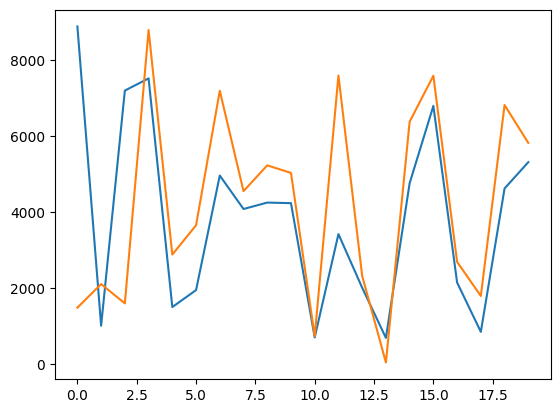

In [374]:
ry = st.rankdata(y[:n0])
rscore = st.rankdata(score)
plt.plot(ry[:20])
plt.plot(rscore[:20])
plt.show()

In [342]:
-sum(np.log(0.6 * Ohat[j, 0]+ 0.4 * Ohat[j, 1])* d[0,j]  for j in WS_index)


56.180005918956795

0.8545454545454544 0.0


In [381]:
st.rankdata(multi_y[0][:10])

array([10.,  1.,  8.,  9.,  2.,  3.,  7.,  4.,  6.,  5.])

In [382]:
st.rankdata(multi_score[0][:10])

array([ 1.,  3.,  2., 10.,  4.,  5.,  9.,  6.,  8.,  7.])

In [306]:
print(np.mean(coef),np.std(coef))

-0.018336757695070382 0.0


In [390]:
spearmanr([1,3,5,4], [10,7,9,8])

SpearmanrResult(correlation=1.0, pvalue=0.0)

In [303]:
def pmle_objectfunction(X):
    # maxmize the object function
   

    # objfun = -sum(np.log(X * Ohat[j, 0]+ (1-X) * Ohat[j, 1])* W_test[i,j]  for j in range(len(WS_index)))/sum(W_test[i,:])- lam * np.log(X*(1-X))
    # objfun = -sum(np.log(X * Ohat[j, 0]+ (1-X) * Ohat[j, 1])* W_test[i,j]  for j in WS_index0)/sum(W_test[i,:])- lam * np.log(X*(1-X))
    objfun = -np.log(X*(1-X))
    return objfun
solution = minimize_scalar(pmle_objectfunction, bounds=(0.0000001,0.9999999), method='bounded')
solution.x

0.5000000000000001

In [ ]:
'''
Author: Naixin && naixinguo2-c@my.cityu.edu.hk
Date: 2022-11-04 22:45:47
LastEditors: Naixin && naixinguo2-c@my.cityu.edu.hk
LastEditTime: 2022-11-23 12:59:06
FilePath: /Gtext/reproduction/xiu/selectword_view1.ipynb
Description: 

'''
##### sbar half######
###XIU DGP#######
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
import scipy.stats as st
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
np.random.seed(66)
def idfunc1(j):
    return 1 if j<S/2  else 0
def idfunc2(j):
    return 1 if j>=S/2  else 0
n = 10000
n0 = 9000
m = 500
S = 100
sbar = 5
nbar = 100
epoch = 200

multi_WS_index=[0]*(S+1)
multi_Ohatplus = []
multi_Ohatminus = []
multi_score =[]
multi_y = []

# np.random.seed(66)
for _ in tqdm(range(epoch)):
    p = np.random.uniform(0,1,n)
    si = np.random.uniform(0,2*sbar,n)
    ni = np.random.uniform(0,2*nbar,n)
    omiga = np.array([1/(m-S)*np.random.uniform(0,2) for _ in range(S,m)])
    # omiga = preprocessing.normalize(omiga.reshape(-1, 1))[:,0]
    print(omiga.shape)
    Oplus = np.array([2/S * (1-j/S)**2 + 2/(3*S) * idfunc1(j) for j in range(S)])
    Ominus = np.array([2/S * (j/S)**2 + 2/(3*S) * idfunc2(j) for j in range(S)])
    F = (Oplus + Ominus)/2
    T = (Oplus - Ominus)/2
    dsi = [(np.random.multinomial(si[i], (p[i]*Oplus + (1-p[i])*Ominus)/ sum(p[i]*Oplus + (1-p[i])*Ominus),S)[0])for i in range(n)]
    dni = [(np.random.multinomial(ni[i], omiga/sum(omiga), m-S ))[0] for i in range(n)]
    d = [list(dsi[i])+list(dni[i]) for i in range(n)]
    d = np.array(d,dtype=object)
    y =np.abs(np.random.standard_t(4, size=n))
    ysign = np.zeros(n)
    pindex=list(np.nonzero([np.random.binomial(1,p[i],1) for i in range(n)])[0])
    nindex=list(set(range(n))-set(pindex))
    ysign[pindex] = 1
    ysign[nindex] = -1
    y = y*ysign
    multi_y.append(y)
    WS_pos_index,WS_neg_index,fq_pos,fq_neg = SESTM1(d[:n0], y[:n0],int(S/2),int(S/2), 0.1)
    WS_index = WS_pos_index + WS_neg_index
    sortedindex = sorted(WS_index)
    for i in sortedindex :
        if i < S:
            multi_WS_index[i]+=1
        else:
            multi_WS_index[S]+=1 
    Ohat = SESTM2(d[:n0], y[:n0],sorted(WS_index))
    multi_Ohatplus.append((Ohat[:,0]+Ohat[:,1])/2)
    multi_Ohatminus.append((Ohat[:,0]-Ohat[:,1])/2)  
    
    score = sentiment_score(d[n0:],Ohat, sorted(WS_index),lam=0.5)
    multi_score.append(score)
    # plt.plot(sortedindex ,(Ohat[sortedindex ,0]+Ohat[sortedindex ,1])/2)
    # plt.plot(sortedindex ,(Ohat[sortedindex ,0]-Ohat[sortedindex ,1])/2)

###save variables    
import joblib
joblib.dump(multi_Ohatminus, 'sbar_half_multi_Ohatminus.pkl')
joblib.dump(multi_Ohatplus, 'sbar_half_multi_Ohatplus.pkl')
joblib.dump(multi_score, 'sbar_half_multi_score.pkl')
joblib.dump(multi_WS_index, 'sbar_half_multi_WS_index.pkl')
joblib.dump(multi_y, 'sbar_half_multi_y')
joblib.dump(T,'sbar_half_T.pkl')
joblib.dump(F,'sbar_half_F.pkl')

    

(100,)

In [ ]:
'''
Author: Naixin && naixinguo2-c@my.cityu.edu.hk
Date: 2022-11-04 22:45:47
LastEditors: Naixin && naixinguo2-c@my.cityu.edu.hk
LastEditTime: 2022-11-23 12:59:06
FilePath: /Gtext/reproduction/xiu/selectword_view1.ipynb
Description: 

'''
##### n half######
###XIU DGP#######
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
import scipy.stats as st
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
np.random.seed(66)
def idfunc1(j):
    return 1 if j<S/2  else 0
def idfunc2(j):
    return 1 if j>=S/2  else 0
n = 5000
n0 = 4500
m = 500
S = 100
sbar = 10
nbar = 100
epoch = 200

multi_WS_index=[0]*(S+1)
multi_Ohatplus = []
multi_Ohatminus = []
multi_score =[]
multi_y = []

# np.random.seed(66)
for _ in tqdm(range(epoch)):
    p = np.random.uniform(0,1,n)
    si = np.random.uniform(0,2*sbar,n)
    ni = np.random.uniform(0,2*nbar,n)
    omiga = np.array([1/(m-S)*np.random.uniform(0,2) for _ in range(S,m)])
    # omiga = preprocessing.normalize(omiga.reshape(-1, 1))[:,0]
    print(omiga.shape)
    Oplus = np.array([2/S * (1-j/S)**2 + 2/(3*S) * idfunc1(j) for j in range(S)])
    Ominus = np.array([2/S * (j/S)**2 + 2/(3*S) * idfunc2(j) for j in range(S)])
    F = (Oplus + Ominus)/2
    T = (Oplus - Ominus)/2
    dsi = [(np.random.multinomial(si[i], (p[i]*Oplus + (1-p[i])*Ominus)/ sum(p[i]*Oplus + (1-p[i])*Ominus),S)[0])for i in range(n)]
    dni = [(np.random.multinomial(ni[i], omiga/sum(omiga), m-S ))[0] for i in range(n)]
    d = [list(dsi[i])+list(dni[i]) for i in range(n)]
    d = np.array(d,dtype=object)
    y =np.abs(np.random.standard_t(4, size=n))
    ysign = np.zeros(n)
    pindex=list(np.nonzero([np.random.binomial(1,p[i],1) for i in range(n)])[0])
    nindex=list(set(range(n))-set(pindex))
    ysign[pindex] = 1
    ysign[nindex] = -1
    y = y*ysign
    multi_y.append(y)
    WS_pos_index,WS_neg_index,fq_pos,fq_neg = SESTM1(d[:n0], y[:n0],int(S/2),int(S/2),0.1)
    WS_index = WS_pos_index + WS_neg_index
    sortedindex = sorted(WS_index)
    for i in sortedindex :
        if i < S:
            multi_WS_index[i]+=1
        else:
            multi_WS_index[S]+=1 
    Ohat = SESTM2(d[:n0], y[:n0],sorted(WS_index))
    multi_Ohatplus.append((Ohat[:,0]+Ohat[:,1])/2)
    multi_Ohatminus.append((Ohat[:,0]-Ohat[:,1])/2)  
    
    score = sentiment_score(d[n0:],Ohat, sorted(WS_index),lam=0.5)
    multi_score.append(score)
    # plt.plot(sortedindex ,(Ohat[sortedindex ,0]+Ohat[sortedindex ,1])/2)
    # plt.plot(sortedindex ,(Ohat[sortedindex ,0]-Ohat[sortedindex ,1])/2)

###save variables    
import joblib
joblib.dump(multi_Ohatminus, 'n_half_multi_Ohatminus.pkl')
joblib.dump(multi_Ohatplus, 'n_half_multi_Ohatplus.pkl')
joblib.dump(multi_score, 'n_half_multi_score.pkl')
joblib.dump(multi_WS_index, 'n_half_multi_WS_index.pkl')
joblib.dump(multi_y, 'n_half_multi_y')
joblib.dump(T,'n_half_T.pkl')
joblib.dump(F,'n_half_F.pkl')

    

In [ ]:
'''
Author: Naixin && naixinguo2-c@my.cityu.edu.hk
Date: 2022-11-04 22:45:47
LastEditors: Naixin && naixinguo2-c@my.cityu.edu.hk
LastEditTime: 2022-11-23 12:59:06
FilePath: /Gtext/reproduction/xiu/selectword_view1.ipynb
Description: 

'''
##### m half######
###XIU DGP#######
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
import scipy.stats as st
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
np.random.seed(66)
def idfunc1(j):
    return 1 if j<S/2  else 0
def idfunc2(j):
    return 1 if j>=S/2  else 0
n = 10000
n0 = 9000
m = 250
S = 100
sbar = 10
nbar = 100
epoch = 200

multi_WS_index=[0]*(S+1)
multi_Ohatplus = []
multi_Ohatminus = []
multi_score =[]
multi_y = []

# np.random.seed(66)
for _ in tqdm(range(epoch)):
    p = np.random.uniform(0,1,n)
    si = np.random.uniform(0,2*sbar,n)
    ni = np.random.uniform(0,2*nbar,n)
    omiga = np.array([1/(m-S)*np.random.uniform(0,2) for _ in range(S,m)])
    # omiga = preprocessing.normalize(omiga.reshape(-1, 1))[:,0]
    print(omiga.shape)
    Oplus = np.array([2/S * (1-j/S)**2 + 2/(3*S) * idfunc1(j) for j in range(S)])
    Ominus = np.array([2/S * (j/S)**2 + 2/(3*S) * idfunc2(j) for j in range(S)])
    F = (Oplus + Ominus)/2
    T = (Oplus - Ominus)/2
    dsi = [(np.random.multinomial(si[i], (p[i]*Oplus + (1-p[i])*Ominus)/ sum(p[i]*Oplus + (1-p[i])*Ominus),S)[0])for i in range(n)]
    dni = [(np.random.multinomial(ni[i], omiga/sum(omiga), m-S ))[0] for i in range(n)]
    d = [list(dsi[i])+list(dni[i]) for i in range(n)]
    d = np.array(d,dtype=object)
    y =np.abs(np.random.standard_t(4, size=n))
    ysign = np.zeros(n)
    pindex=list(np.nonzero([np.random.binomial(1,p[i],1) for i in range(n)])[0])
    nindex=list(set(range(n))-set(pindex))
    ysign[pindex] = 1
    ysign[nindex] = -1
    y = y*ysign
    multi_y.append(y)
    WS_pos_index,WS_neg_index,fq_pos,fq_neg = SESTM1(d[:n0], y[:n0],int(S/2),int(S/2), 0.1)
    WS_index = WS_pos_index + WS_neg_index
    sortedindex = sorted(WS_index)
    for i in sortedindex :
        if i < S:
            multi_WS_index[i]+=1
        else:
            multi_WS_index[S]+=1 
    Ohat = SESTM2(d[:n0], y[:n0],sorted(WS_index))
    multi_Ohatplus.append((Ohat[:,0]+Ohat[:,1])/2)
    multi_Ohatminus.append((Ohat[:,0]-Ohat[:,1])/2)  
    
    score = sentiment_score(d[n0:],Ohat, sorted(WS_index),lam=0.5)
    multi_score.append(score)
    # plt.plot(sortedindex ,(Ohat[sortedindex ,0]+Ohat[sortedindex ,1])/2)
    # plt.plot(sortedindex ,(Ohat[sortedindex ,0]-Ohat[sortedindex ,1])/2)

###save variables    
import joblib
joblib.dump(multi_Ohatminus, 'm_half_multi_Ohatminus.pkl')
joblib.dump(multi_Ohatplus, 'm_half_multi_Ohatplus.pkl')
joblib.dump(multi_score, 'm_half_multi_score.pkl')
joblib.dump(multi_WS_index, 'm_half_multi_WS_index.pkl')
joblib.dump(multi_y, 'm_half_multi_y')
joblib.dump(T,'m_half_T.pkl')
joblib.dump(F,'m_half_F.pkl')

    

In [ ]:
'''
Author: Naixin && naixinguo2-c@my.cityu.edu.hk
Date: 2022-11-04 22:45:47
LastEditors: Naixin && naixinguo2-c@my.cityu.edu.hk
LastEditTime: 2022-11-23 12:59:06
FilePath: /Gtext/reproduction/xiu/selectword_view1.ipynb
Description: 

'''
##### S half######
###XIU DGP#######
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
import scipy.stats as st
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
np.random.seed(66)
def idfunc1(j):
    return 1 if j<S/2  else 0
def idfunc2(j):
    return 1 if j>=S/2  else 0
n = 10000
n0 = 9000
m = 500
S = 50
sbar = 10
nbar = 100
epoch = 200

multi_WS_index=[0]*(S+1)
multi_Ohatplus = []
multi_Ohatminus = []
multi_score =[]
multi_y = []

# np.random.seed(66)
for _ in tqdm(range(epoch)):
    p = np.random.uniform(0,1,n)
    si = np.random.uniform(0,2*sbar,n)
    ni = np.random.uniform(0,2*nbar,n)
    omiga = np.array([1/(m-S)*np.random.uniform(0,2) for _ in range(S,m)])
    # omiga = preprocessing.normalize(omiga.reshape(-1, 1))[:,0]
    print(omiga.shape)
    Oplus = np.array([2/S * (1-j/S)**2 + 2/(3*S) * idfunc1(j) for j in range(S)])
    Ominus = np.array([2/S * (j/S)**2 + 2/(3*S) * idfunc2(j) for j in range(S)])
    F = (Oplus + Ominus)/2
    T = (Oplus - Ominus)/2
    dsi = [(np.random.multinomial(si[i], (p[i]*Oplus + (1-p[i])*Ominus)/ sum(p[i]*Oplus + (1-p[i])*Ominus),S)[0])for i in range(n)]
    dni = [(np.random.multinomial(ni[i], omiga/sum(omiga), m-S ))[0] for i in range(n)]
    d = [list(dsi[i])+list(dni[i]) for i in range(n)]
    d = np.array(d,dtype=object)
    y =np.abs(np.random.standard_t(4, size=n))
    ysign = np.zeros(n)
    pindex=list(np.nonzero([np.random.binomial(1,p[i],1) for i in range(n)])[0])
    nindex=list(set(range(n))-set(pindex))
    ysign[pindex] = 1
    ysign[nindex] = -1
    y = y*ysign
    multi_y.append(y)
    WS_pos_index,WS_neg_index,fq_pos,fq_neg = SESTM1(d[:n0], y[:n0],int(S/2),int(S/2), 0.1)
    WS_index = WS_pos_index + WS_neg_index
    sortedindex = sorted(WS_index)
    for i in sortedindex :
        if i < S:
            multi_WS_index[i]+=1
        else:
            multi_WS_index[S]+=1 
    Ohat = SESTM2(d[:n0], y[:n0],sorted(WS_index))
    multi_Ohatplus.append((Ohat[:,0]+Ohat[:,1])/2)
    multi_Ohatminus.append((Ohat[:,0]-Ohat[:,1])/2)  
    
    score = sentiment_score(d[n0:],Ohat, sorted(WS_index),lam=0.5)
    multi_score.append(score)
    # plt.plot(sortedindex ,(Ohat[sortedindex ,0]+Ohat[sortedindex ,1])/2)
    # plt.plot(sortedindex ,(Ohat[sortedindex ,0]-Ohat[sortedindex ,1])/2)

###save variables    
import joblib
joblib.dump(multi_Ohatminus, 'S_half_multi_Ohatminus.pkl')
joblib.dump(multi_Ohatplus, 'S_half_multi_Ohatplus.pkl')
joblib.dump(multi_score, 'S_half_multi_score.pkl')
joblib.dump(multi_WS_index, 'S_half_multi_WS_index.pkl')
joblib.dump(multi_y, 'S_half_multi_y')
joblib.dump(T,'S_half_T.pkl')
joblib.dump(F,'S_half_F.pkl')

    

In [32]:
multi_WS_index = joblib.load('./xiudgp/multi_WS_index .pkl')


array([[0.01287014, 0.01342278],
       [0.01376733, 0.01334616],
       [0.01285948, 0.01404807],
       [0.01262998, 0.01337695],
       [0.012755  , 0.01174055],
       [0.01206007, 0.01293924],
       [0.01227696, 0.0124327 ],
       [0.0111618 , 0.01349239],
       [0.01187926, 0.0110445 ],
       [0.01261707, 0.01200377]])

In [ ]:
x = np.linspace(0, S-1 , num =S)
Low_CI_bound,High_CI_bound = st.t.interval(0.95,S-1,loc = np.mean(multi_Ohatplus,0),scale =st.sem(multi_Ohatplus))
low_CI_bound,high_CI_bound = st.t.interval(0.95,S-1,loc = np.mean(multi_Ohatminus,0),scale =st.sem(multi_Ohatminus))
plt.fill_between(x,Low_CI_bound,High_CI_bound,alpha=0.5,label='95% conf bands of F')
plt.fill_between(x,low_CI_bound,high_CI_bound,alpha=0.5,label='95% conf bands of T')
plt.plot(range(S) ,np.mean(multi_Ohatplus,0))
plt.plot(range(S),np.mean(multi_Ohatminus,0))    

plt.plot(range(S),F)    
plt.plot(range(S),T)
plt.legend()
plt.show() 

figureI=plt.figure(figsize=(5,3))
plt.bar(range(1,S+2),np.array(multi_WS_index)/epoch)  
plt.show()
    

In [101]:
for i in list(p[p>0.5]):
    ererer.append(list(p).index(i))

In [100]:
trtrtr=[]
ererer=[]
for i in list(y[y>0]):
    trtrtr.append(list(y).index(i))
    

In [104]:
len(set(trtrtr)&set(ererer))

3735

In [105]:
print(len(trtrtr),len(ererer))

4988 4979


In [50]:
np.mean([Ohat[:3,0],Ohat[:3,1]],0)

array([0.0129373 , 0.01232443, 0.01241521])

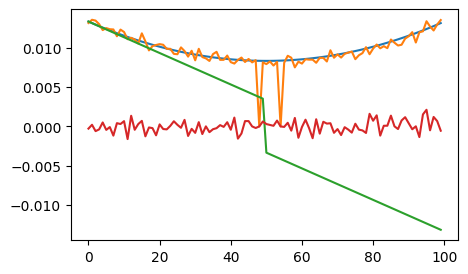

In [24]:

import matplotlib
import matplotlib.pyplot as plt
figure=plt.figure(figsize=(5,3))
# plt.plot(sing_vals,svdtest.singular_values_/100, 'x-', markersize=3,linewidth=1)
sortedindex = sorted(WS_index)
plt.plot(range(S),F)
plt.plot(range(S) ,(Ohat[:S ,0]+Ohat[:S,1])/2)
plt.plot(range(S),T)
plt.plot(range(S) ,(Ohat[:S ,0]-Ohat[:S,1])/2)

# plt.title('')
# plt.xlabel('')
# plt.ylabel('') 
plt.show() 


In [1]:
#DGP
import numpy as np
import pandas as pd
import random

# n = 200  #firm num
# T = 100  #time num
#To simplify the simulation, we change the x_{i,(t-1)} ,r_{i,t} to x_n, r_n, 
# which means denote all the variable with  n th news rather than i th firm in t th day
np.random.seed(66)
S = 2000  #word num
n = 5000  #news num
p = 1 #dim of latent space

#x ~ Normal
mu_x = 0.5
sigma_x = 0.05
x = np.random.normal(mu_x,sigma_x,(n,p))  #latent variable n x p

# beta controls signal-noise ratio 0.5, 10, 100 ###normal?
beta = np.random.normal(0.1,0,p) 
#noise~ Normal
sigma_epsilon = 0.05
epsilon = np.random.normal(0,sigma_epsilon,n)

# return
r = x @ beta + epsilon 
ratio_r = np.var(x @ beta)/(np.var(x @ beta)+np.var(epsilon))

#Gamma controls sentiment signals S x p
K = 10 #num of neg/pos sentiment words nums
s1 = 1 #lower bound of the sentiment strength  (non-neg)
s2 = 5 #upper bound of the sentiment strength 
gamma = np.zeros((S,p))  
gamma[:K] = np.random.uniform(s1,s2,(K,p)) 
gamma[-K:] = np.random.uniform(-s2,-s1,(K,p))

#theta control the sparsity of word matrix W
mu_b = 0.5
mu_theta = -5
sigma_theta = 0.05
theta = np.random.binomial(1, mu_b,(n,S)) * np.random.normal(mu_theta, sigma_theta,(n,S))

#paramenter of Poisson distribution
lam = np.exp( x @ gamma.T + theta)

# words count matrix
W = np.random.poisson(lam,(n,S))


# words count of each article
total_words_example = np.mean(np.sum(W,axis=1))

## calculate sparcity 
sparcity = 1 - np.count_nonzero(W)/W.size

print("sparsity of W:", sparcity)
print("signal-to-noise ratio:", ratio_r)
print("neg return num:",np.sum(r<0))

W_train = W[:3000]
r_train = r[:3000]
W_test = W[3000:]
r_test = r[3000:]


sparsity of W: 0.6807477
signal-to-noise ratio: 0.009685151609198344
neg return num: 741


In [ ]:
len(np.nonzero(d[:,0])[0])

1099

In [189]:
'''
Author: Naixin && naixinguo2-c@my.cityu.edu.hk
Date: 2022-11-01 14:50:18
LastEditors: Naixin && naixinguo2-c@my.cityu.edu.hk
LastEditTime: 2022-11-04 22:31:35
FilePath: /Gtext/xiu/fixword_ex.ipynb
Description: 

'''

import heapq
from collections import Counter
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
import scipy.stats as st
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
def SESTM1(W_train, r_train, alpha_posnum, alpha_negnum, kappa):
    n, S = W_train.shape

    ###################Screening Part##############
    #####each year have appearance_word list#####
    # appearance_word = df_words.TotalBodyNum
    appearance_word = sum(W_train>0)
    print(np.quantile(appearance_word,kappa))

    # appearance_word = df_words.TotalBodyNum
    # yearcount = dict(Counter([datearray[i][:4] for i in range(n)]))
    # start = 0
    freq_index = []
    # for key, value in yearcount.items():
    #     print(key, value)
    #     appearance_word0 = sum(W_train[start:start + value]>0)
    #     # freq_index = list({np.where(appearance_word0 > np.quantile(appearance_word0, kappa))[0]}.union(freq_index))
    #     print('print(np.quantile(appearance_word,kappa))',np.quantile(appearance_word0,kappa))
    #     freq_index =list(set(np.where(appearance_word0 >= np.quantile(appearance_word0,kappa))[0]).union(set(freq_index)))
    #     # print(len(appearance_word0),len(freq_index))
    #     start += value
    #         # print(len(freq_index))
    # print(len(appearance_word),len(freq_index))

    freq_index =list(np.where(appearance_word >= np.quantile(appearance_word,kappa))[0])
    print(len(freq_index))
    # print(np.quantile(appearance_word,kappa))
    # pi = sum(np.array([r_train[i] for i in freq_index])>0)/len(freq_index)
    pi = sum(r_train>0)/len(r_train)
    print('pi',pi)
    # pi=0.5
    WS_pos_index = []  #index of the positive sentiment word
    WS_neg_index = []  #index of the negative sentiment word
    fq_pos = {}
    fq_neg = {}

    for i in freq_index:
        # calculte f* to screen
        i_index = np.nonzero(W_train[:,i])[0] # count of word i appearance in all article
        # print(i)
        # print(len(i_index))
        # # print(df_words.TotalBodyNum[i])
        # print(appearance_word[i])
        num_i_index = len(i_index)
        
        f_r = sum(r_train[i_index]>0) # count of word i in all articles and having r>0   
        # print(f_r)
        # print(f_r/quantile_word[i])
        if f_r/num_i_index  >= pi:
        # if f_r/appearance_word[i] >= pi:
            # fq_pos[i] = f_r/appearance_word[i]  
            fq_pos[i] = f_r/num_i_index   
            # if  fq_pos[i] ==1:
            #     print(i,appearance_word[i])
        else:
            # fq_neg[i] = f_r/appearance_word[i]
            fq_neg[i] = f_r/num_i_index    
            # if  fq_neg[i] ==0:
            #     print(i,appearance_word[i])
        # if i ==2597:
        #     print( 'hi',f_r/num_i_index,f_r,num_i_index)
        # if i ==1670:
        #     print( 'hi',f_r/num_i_index,f_r,num_i_index)
    # print("fq_pos",fq_pos)
    # print('print(fq_neg)  ',fq_neg)  
    WS_pos_index = heapq.nlargest(alpha_posnum, fq_pos, key=lambda x: fq_pos[x])
    # print(len(WS_pos_index)) 
    WS_neg_index = heapq.nsmallest(alpha_negnum, fq_neg, key=lambda x: fq_neg[x])
    
    # print([fq_pos[i] for i in WS_pos_index])
    # print([fq_neg[i] for i in WS_neg_index])
    ###################Screening Part##############
    
    return WS_pos_index, WS_neg_index, fq_pos , fq_neg

# WS_pos_index,WS_neg_index,fq_pos,fq_neg = SESTM1(W_train, r_train, 50, 50, 0.92)
# WS_pos_index,WS_neg_index = SESTM1(W_train, r_train, alpha_posnum, alpha_negnum, kappa)
# print(stkcd_array[WS_pos_index,:])


# print([(df_words.final_word[i]) for i in WS_pos_index])
# print([(df_words.final_word[i]) for i in WS_neg_index])
# WS_pos_index,WS_neg_index,fq_pos,fq_neg = SESTM1(d, y, 50, 50, 0.1)

In [ ]:
# import nltk
# from nltk.corpus import words
# from nltk.corpus import wordnet
# from nltk.corpus import brown
# #nltk.download('wordnet')
# # nltk.download('words')
# words1 = set(nltk.corpus.words.words())
# words2 = set(nltk.corpus.wordnet.words())
# words3 = set(nltk.corpus.brown.words())
# print(len(words1),len(words2),len(words3))
# print('aaa' in words1,'aaa' in words2,'aaa' in words3)
# print('the' in words1,'the' in words2,'the' in words3)
# print('th' in words1,'th' in words2,'th' in words3)
# print('penni' in words1,'penni' in words2,'penni' in words3)
# print('p' in words1,'p' in words2,'p' in words3)
print('sweeter' in words1,'sweeter' in words2,'sweeter' in words3)
print('worst' in words1,'worst' in words2,'worst' in words3)
print('consumption' in words1,'consumption' in words2,'consumption' in words3)





False False True
True True True


In [ ]:
print('abound' in words1,'abound' in words2,'abound' in words3)
print('picked' in words1,'picked' in words2,'picked' in words3)
print('colored' in words1,'colored' in words2,'colored' in words3)
print('jumps' in words1,'jumps' in words2,'jumps' in words3)
print('disappointing' in words1,'disappointing' in words2,'disappointing' in words3)
print('dancing' in words1,'dancing' in words2,'dancing' in words3)
print('looking' in words1,'looking' in words2,'looking' in words3)

True True True
True False True
True True True
False False True
True True True
True True True
True True True


In [40]:
sum(s[0,:])

11.0

In [45]:
phat

array([0.187 , 0.3826, 0.5066, ..., 0.9677, 0.8698, 0.0647])

In [154]:
n, S =d.shape
# n = len(W_train)
# S = len(W_train[0])
############################Estimation Part ############################  
r_order = np.argsort(y)+1
phat = r_order/n # n
  
s =d[:,sortedindex]
hhat = np.zeros((n,len(WS_index)) )
for i in range(n):
    if sum(s[i,:])!=0:
        hhat[i] = s[i,:]/sum(s[i,:])

hhat = np.array(hhat) # specific sentiment word frequency in each article S x n
Pmatrix = np.array([phat,1-phat])

P_inverse = np.linalg.inv(Pmatrix @ Pmatrix.T) #2 x 2

# estimated theta
# Ohat = P_inverse @ Pmatrix @ hhat

Ohat = hhat.T@ Pmatrix.T @P_inverse 
Ohat[Ohat < 0] = 0
Ohat = preprocessing.normalize(Ohat.T, norm='l1').T # S x 2
    

In [ ]:
# plt.figure(figsize=(5,3))

# plt.plot(sorted((Ohat[:S ,0]-Ohat[:S,1])/2,reverse=True))
# plt.plot(T)
# plt.show()
Ohat

In [156]:
Ohat[Ohat < 0] = 0
 
Ohat = preprocessing.normalize(Ohat.T, norm='l1').T # S x 2

(-0.5, 399.5, 199.5, -0.5)

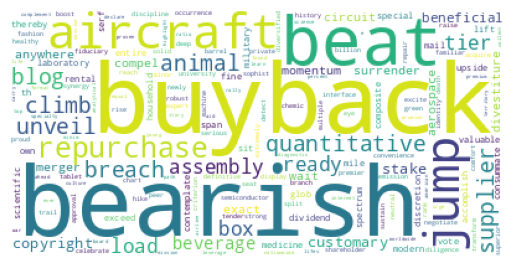

In [ ]:
import numpy as np
import pandas as pd
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
from PIL import Image

fq_pos = {df_words.final_word[k]: v for k, v in fq_pos.items()}
# print(fq_pos0)
plt.imshow(WordCloud(background_color='white').generate_from_frequencies(frequencies=fq_pos))
plt.axis("off")


(-0.5, 399.5, 199.5, -0.5)

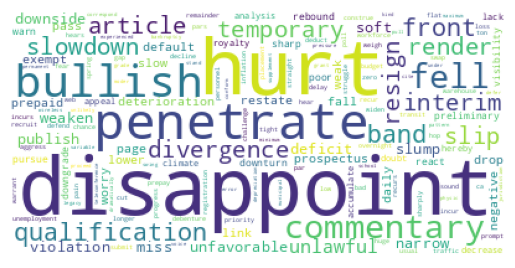

In [ ]:
import numpy as np
import pandas as pd
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
from PIL import Image
fq_neg = {df_words.final_word[k]: 1-v for k, v in fq_neg.items()}
        
plt.imshow(WordCloud(background_color='white').generate_from_frequencies(frequencies=fq_neg))
plt.axis("off")

In [243]:
import numpy as np
import pandas as pd
import heapq
from tqdm import tqdm
import time
from sklearn import preprocessing
from scipy import stats as st
# d_pos = [list(df_words.TotalBodyNum)[i] for i in index_neg_word_xiu]
# d_neg =  [list(df_words.TotalBodyNum)[i] for i in index_neg_word_xiu]
# WS_index = WS_pos_index + WS_neg_index

def SESTM2(W_train, r_train, WS_index):

    n, S = W_train.shape
    # n = len(W_train)
    # S = len(W_train[0])
    ############################Estimation Part ############################  
    # r_order = np.argsort(r_train)+1
   
    r_order = st.rankdata(r_train)
    phat = r_order/n # n
    
    # s = np.zeros((n,len(WS_index))) # construct a matrix only contains sentiment words
    s = W_train[:,WS_index]
    hhat = np.zeros((n,len(WS_index))) 
    for i in range(n):
        if sum(s[i,:])!=0:
            hhat[i] = s[i,:]/sum(s[i,:])

    hhat = np.array(hhat) # specific sentiment word frequency in each article S x n
   
    Pmatrix = np.array([phat,1-phat])
    
    P_inverse = np.linalg.inv(Pmatrix @ Pmatrix.T) #2 x 2
    
    # estimated theta
    # Ohat = P_inverse @ Pmatrix @ hhat

    Ohat = hhat.T@ Pmatrix.T @P_inverse 
    
    Ohat[Ohat < 0] = 0
 
    Ohat = preprocessing.normalize(Ohat.T, norm='l1').T # S x 2
    return Ohat

# Ohat = SESTM2(W_train, r_train, WS_index)

In [ ]:
[df_words.final_word[k] for k in np.nonzero(Ohat)[0]]

In [339]:

from scipy.optimize import minimize_scalar
def sentiment_score(W_test, Ohat, WS_index,lam):
    '''
    Input:
        W_test: Out-of-Sample sparse matrix
        Ohat: thetahat obtained from function sestm
        lam: lambda value
    Return:
        p_new: predicted sentiment score
    '''
    #test sample size
    n,S = W_test.shape  
    p_new = []
    W_test = W_test[:,WS_index]
    # score each article's sentiment
    for i in tqdm(range(n)):   
        
        if not sum(W_test[i,:]):   # no sentiment word found
            p_new.append(0.5)
        else:
            def pmle_objectfunction(X):
                # maxmize the object function
                WS_index0 = np.nonzero(W_test[i,:])[0]
            
                # objfun = -sum(np.log(X * Ohat[j, 0]+ (1-X) * Ohat[j, 1])* W_test[i,j]  for j in range(len(WS_index)))/sum(W_test[i,:])- lam * np.log(X*(1-X))
                objfun = -sum(np.log(X * Ohat[j, 0]+ (1-X) * Ohat[j, 1])* W_test[i,j]  for j in WS_index0)/sum(W_test[i,:])-lam * np.log(X*(1-X))
                
                return objfun
            solution = minimize_scalar(pmle_objectfunction, bounds=(0.0000001,0.9999999), method='bounded')
        
            # append sentiment score
            p_new.append(solution.x)
         
            # optimal_p = fminbound(lambda x: pmle_objectfunction(x),0,1)
            # print(optimal_p)
    return p_new

# p = sentiment_score(W_test, Ohat, WS_index,lam=1)

In [281]:
np.nonzero(d[10,:])[0]

array([ 28,  68,  70,  78,  81,  84,  85,  93,  95,  98, 100, 103, 107,
       111, 115, 125, 129, 132, 135, 139, 144, 145, 148, 150, 151, 154,
       156, 162, 166, 167, 171, 177, 180, 182, 191, 194, 205, 209, 221,
       241, 246, 249, 255, 265, 267, 272, 276, 289, 291, 297, 298, 300,
       301, 303, 310, 314, 318, 320, 324, 330, 333, 341, 349, 359, 362,
       365, 370, 371, 377, 379, 391, 394, 395, 396, 402, 405, 430, 436,
       438, 439, 440, 442, 445, 450, 451, 453, 455, 460, 464, 467, 472,
       475, 480, 490])

(-0.5, 399.5, 199.5, -0.5)

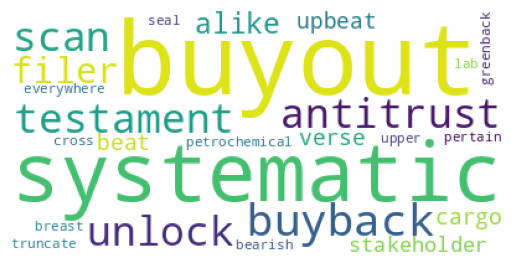

In [ ]:
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
fq_pos,fq_neg ={},{}
for i in WS_index[:25]:
    i_index = np.nonzero(W_vali[:,i])[0] # count of word i appearance in all article
    num_i_index = len(i_index)
    f_r = sum(r_vali[i_index]>0) 
    fq_pos[i] = f_r/num_i_index

for i in WS_index[25:]:
    i_index = np.nonzero(W_vali[:,i])[0] # count of word i appearance in all article
    num_i_index = len(i_index)
    f_r = sum(r_vali[i_index]>0) 
    fq_neg[i] = f_r/num_i_index

fq_pos = {df_words.final_word[k]: v for k, v in fq_pos.items()}
# print(fq_pos0)
plt.imshow(WordCloud(background_color='white').generate_from_frequencies(frequencies=fq_pos))
plt.axis("off")  

(-0.5, 399.5, 199.5, -0.5)

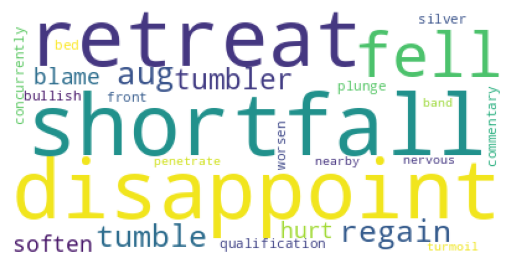

In [ ]:
fq_neg = {df_words.final_word[k]: 1-v for k, v in fq_neg.items()}
# print(fq_pos0)
plt.imshow(WordCloud(background_color='white').generate_from_frequencies(frequencies=fq_neg))
plt.axis("off")    

In [ ]:
'''
Author: Naixin && naixinguo2-c@my.cityu.edu.hk
Date: 2022-11-04 22:49:01
LastEditors: Naixin && naixinguo2-c@my.cityu.edu.hk
LastEditTime: 2022-11-08 16:41:05
FilePath: /Gtext/xiu/selectword_view2.ipynb
Description: 

'''
import numpy as np
import pandas as pd
from tqdm import tqdm
import itertools

# loss function of validation set

def Hyperparam(W_train, r_train, W_vali, r_vali, Lam, Alpha_posnum, Kappa):
    def L1_loss(p1, p2):
        return np.sum(np.abs(p1 - p2))
    L1 = 0
    for result in itertools.product(Alpha_posnum,Kappa):    
        print(result)
        # lam = result[0]
        alpha_posnum = result[0]
        alpha_negnum = alpha_posnum
        kappa = result[1]
        ################################################################################################
        
        WS_pos_index,WS_neg_index,fq_pos,fq_neg= SESTM1(W_train, r_train, alpha_posnum, alpha_negnum, kappa)
        WS_index = WS_pos_index + WS_neg_index
        del fq_neg
        del fq_pos
        # ohat = SESTM2(W_train, r_train, ws_index)
        Ohat = SESTM2(W_train, r_train, WS_index)
        for i in Lam:
            p = sentiment_score(W_vali, Ohat, WS_index, i)
            r_order = np.argsort(r_vali) + 1
            phat = r_order/len(r_vali) # n
            if  L1_loss(p, phat) > L1:
                L1 = L1_loss(p, phat)
                hyperparamerter = result    
                lam = i
                print(hyperparamerter,lam)   
    return lam,hyperparamerter, WS_index

Lam = [1]
# Alpha_posnum = [25, 50, 100]
Alpha_posnum = [5,10,15,25]
Alpha_negnum = Alpha_posnum 
Kappa = [0.88]
# Kappa = [0.86,0.88,0.90,0.92,0.94]
lam, (alpha_posnum, kappa),WS_index = Hyperparam(W_train, r_train, W_train, r_train, Lam, Alpha_posnum, Kappa)

In [ ]:
Ohat = SESTM2(W_train, r_train, WS_index)
r1=sentiment_score(W_train, Ohat, WS_index, 1)
print("neg return num:",np.sum(np.array(r1)<0),"neg training return num:",np.sum(np.array(r_train)<0))
r2=sentiment_score(W_test, Ohat, WS_index, 1)
print("neg return num:",np.sum(np.array(r2)<0),"neg testing return num:",np.sum(np.array(r_test)<0))
rankrtrain=(np.argsort(r_train)+1)/len(r_train)
rankrtest=(np.argsort(r_test)+1)/len(r_test)
jobs=30
def calc_R2(y, haty):
    return 1 - np.sum(np.power((y - haty),2))/np.sum(np.power(y,2))

def calc_RMSE(y, haty, n):
    return np.sqrt(np.sum(np.power((y - haty),2))/n)

def calc_perform(W_test,r_test, r):
    '''
    Input:
        n: Number of News, same as input n of Farmpredict
        B: loading, same as output loading of Farmpredict
        W: sparse matrix, same as input W of Farmpredict
        lassoBeta: optimal lasso model's coefficients, same as output lasso_beta of Farmpredict
        r: stock return, same as input r of Farmpredict
        insregLRint: same as output insregLRint of Farmpredict
        insregLRcoef: same as output insregLRcoef of Farmpredict
        lasso_alpha: same as output lasso_alpha of Farmpredict
    Return:
        Rsquare: R2 calculate by function calc_R2
        Rmse: RMSE calculate by function calc_RMSE
        r_new_hat: predicted stock returns
    '''
    
    n,S = W_test.shape
    Rsquare = calc_R2(r_test, r) 
    Rmse = calc_RMSE(r_test, r, n)
    # return r_new_hat
    return Rsquare,Rmse



100%|██████████| 3000/3000 [03:46<00:00, 13.25it/s]


neg return num: 0 neg training return num: 453


100%|██████████| 2000/2000 [02:43<00:00, 12.25it/s]

neg return num: 0 neg testing return num: 288


In [ ]:
print("neg return num:",np.sum(np.array(r1)<0),"neg training return num:",np.sum(np.array(r_train)<0))
print("neg return num:",np.sum(np.array(r2)<0),"neg testing return num:",np.sum(np.array(r_test)<0))
print(calc_perform(W_test,r_test, r2))
print(calc_perform(W_test,rankrtest, r2))
print(calc_perform(W_train,r_train, r1))
print(calc_perform(W_train,rankrtrain, r1))

neg return num: 0 neg training return num: 3
neg return num: 0 neg testing return num: 2
(-3.824086498794961, 0.3517118283895199)
(0.750044250524406, 0.2887578267523204)
(-4.015501328465032, 0.3538241432237042)
(0.750879290693496, 0.2882390694667632)


In [ ]:
print(sorted(WS_index))

[2, 3, 5, 7, 9, 26, 41, 50, 52, 56, 69, 86, 116, 121, 136, 219, 221, 248, 260, 284, 296, 312, 322, 371, 426, 432, 474, 476, 485, 509, 563, 580, 585, 598, 627, 633, 643, 667, 713, 743, 768, 802, 803, 816, 817, 850, 867, 880, 897, 926, 940, 941, 955, 961, 979, 987, 1015, 1033, 1103, 1112, 1119, 1154, 1161, 1184, 1211, 1245, 1261, 1281, 1294, 1296, 1304, 1329, 1346, 1354, 1380, 1415, 1449, 1456, 1473, 1476, 1539, 1569, 1612, 1616, 1626, 1627, 1681, 1694, 1701, 1712, 1717, 1718, 1728, 1800, 1836, 1854, 1899, 1909, 1945, 1952]
